In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.jla_supernovae.jla import *
import simulators.jla_supernovae.jla_parser as jla
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

In [11]:
### SET UP FOR SIMULATION CODE ###
# Import data
jla_data, jla_cmats = jla.b14_parse(z_min=None, z_max=None, qual_cut=False,
                                    jla_path='simulators/jla_supernovae/jla_data/')
data = jla_data['mb']
delta_m_cut = 10
auxiliary_data = np.column_stack([jla_data['zcmb'], jla_data['x1'], jla_data['color'], np.array([(jla_data['3rdvar'] > delta_m_cut)], dtype=int)[0]])

# Om, w0, M_b, alpha, beta, delta_m
npar = 6
theta_fiducial = np.array([  0.20181324,  -0.74762939, -19.04253368,   0.12566322,   2.64387045, -0.05252869])

# Define prior limits and boundaries
lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
Q = np.diag([0.4, 0.75, 0.1, 0.025, 0.25, 0.05])**2
Q[0,1] = Q[1,0] = -0.8*0.4*0.75
Qinv = np.linalg.inv(Q)
prior_mean = np.array([  0.3  ,  -0.75 , -19.05 ,   0.125,   2.6  ,  -0.05 ])
prior_args = [prior_mean, Q, lower, upper]

# Covariance matrix
C = jla.b14_covariance(jla_data, jla_cmats, theta_fiducial[3], theta_fiducial[4])
Cinv = np.linalg.inv(C)
L = np.linalg.cholesky(C)

# Derivative of the covariance matrix
n_sn = len(C)
dCdt = np.zeros((npar, n_sn, n_sn))

# Step size for derivatives
step = abs(0.01*theta_fiducial)

# N data points
ndata = len(jla_data['mb'])

# Simulation args
sim_args = [auxiliary_data, L]

# Compute the mean
mu = apparent_magnitude(theta_fiducial, auxiliary_data)

# Compute the derivatives
dmdt = dmudtheta(theta_fiducial, simulation_seeded, step, npar, ndata, sim_args)
dmdt[2,:] = np.ones(n_sn)
dmdt[3,:] = -jla_data['x1']
dmdt[4,:] = jla_data['color']
dmdt[5,:] = (jla_data['3rdvar'] > 10)

# Fisher matrix
F, Finv = fisher(dmdt, dCdt, Cinv, Qinv, npar)
fisher_errors = np.sqrt(np.diag(Finv))

# Simulation args for ABC
simABC_args = [theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, sim_args]

# Compressed dataset
data = mle(theta_fiducial, Finv, Cinv, dmdt, dCdt, mu, Qinv, prior_mean, data)

/Users/jalsing/Dropbox (Simons Foundation)/science/delfi/DELFI/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [12]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [13]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [14]:
# Create the DELFI MDN object
n_components = 1
names = ['\Omega_m', 'w_0', 'M_\mathrm{B}', '\alpha', '\beta', '\delta M']
labels =  ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M']
ranges = {'\Omega_m':[lower[0], upper[0]], '\w0':[lower[1], upper[1]]}

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 26s 580us/step - loss: 14.5294 - val_loss: 9.7550
Epoch 2/50
45000/45000 [==============================] - 26s 583us/step - loss: 9.0055 - val_loss: 8.3416
Epoch 3/50
45000/45000 [==============================] - 27s 589us/step - loss: 7.8585 - val_loss: 7.4378
Epoch 4/50
45000/45000 [==============================] - 26s 584us/step - loss: 7.2455 - val_loss: 7.0926
Epoch 5/50
45000/45000 [==============================] - 26s 584us/step - loss: 7.0110 - val_loss: 6.9239
Epoch 6/50
45000/45000 [==============================] - 26s 584us/step - loss: 6.8985 - val_loss: 6.9044
Epoch 7/50
45000/45000 [==============================] - 29s 643us/step - loss: 6.8449 - val_loss: 6.8364
Epoch 8/50
45000/45000 [==============================] - 37s 814us/step - loss: 6.8023 - val_loss: 6.7866
Epoch 9/50
45000/45000 [==============================] -

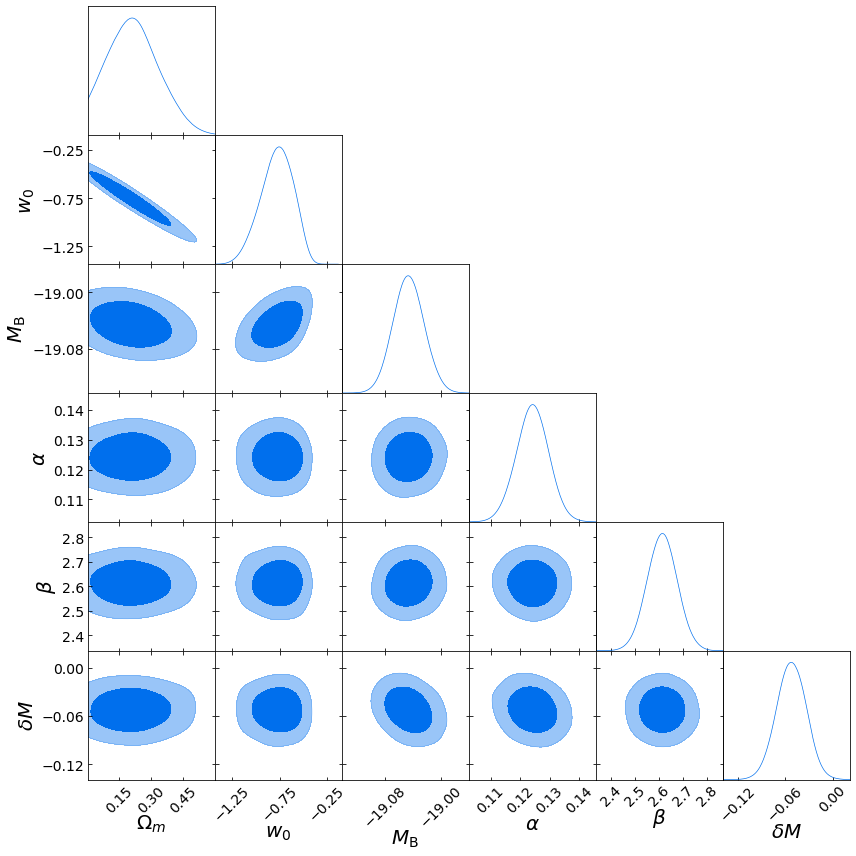

In [15]:
# Proposal for the Fisher pre-training stage
proposal = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Do the Fisher pre-training
mdn.fisher_pretraining(50000, proposal, epochs=50)

Running initial 500 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 0s 725us/step - loss: 11.0490 - val_loss: 9.4433
Epoch 2/100
450/450 [==============================] - 0s 742us/step - loss: 8.8761 - val_loss: 9.7732
Epoch 3/100
450/450 [==============================] - 0s 746us/step - loss: 8.0504 - val_loss: 7.7524
Epoch 4/100
450/450 [==============================] - 0s 729us/step - loss: 7.7050 - val_loss: 7.4908
Epoch 5/100
450/450 [==============================] - 0s 756us/step - loss: 7.2820 - val_loss: 7.7386
Epoch 6/100
450/450 [==============================] - 0s 720us/step - loss: 7.1183 - val_loss: 7.5152
Epoch 7/100
450/450 [==============================] - 0s 754us/step - loss: 7.0678 - val_loss: 7.3715
Epoch 8/100
450/450 [==============================] - 0s 739us/step - loss: 6.9616 - val_loss: 7.4224
Epoch 9/100
450/450 [==============================] - 0s 786us/step - loss: 6.9440 - val_loss: 

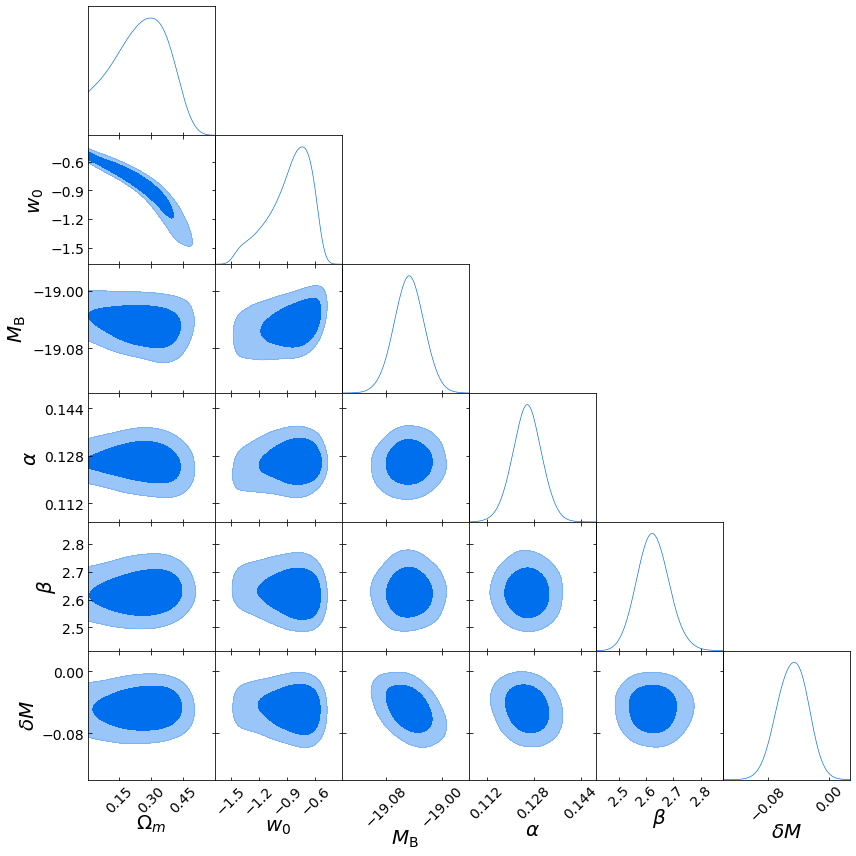

Population 1/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 722us/step - loss: 6.2807 - val_loss: 6.0844
Epoch 2/100
900/900 [==============================] - 1s 755us/step - loss: 6.2566 - val_loss: 6.0477
Epoch 3/100
900/900 [==============================] - 1s 724us/step - loss: 6.2325 - val_loss: 6.0455
Epoch 4/100
900/900 [==============================] - 1s 730us/step - loss: 6.2333 - val_loss: 6.0791
Epoch 5/100
900/900 [==============================] - 1s 730us/step - loss: 6.2363 - val_loss: 6.0839
Epoch 6/100
900/900 [==============================] - 1s 750us/step - loss: 6.2244 - val_loss: 6.0399
Epoch 7/100
900/900 [==============================] - 1s 730us/step - loss: 6.2068 - val_loss: 6.0508
Epoch 8/100
900/900 [==============================] - 1s 748us/step - loss: 6.2010 - val_loss: 6.0704
Epoch 9/100
900/900 [==============================] -

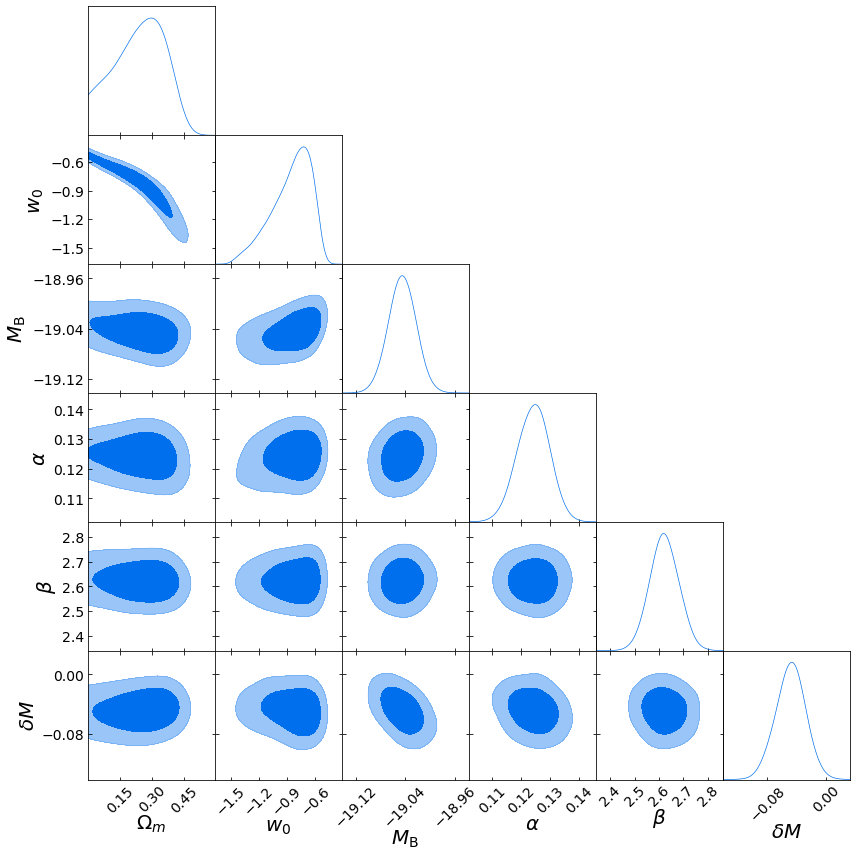

Population 2/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 1s 737us/step - loss: 6.2449 - val_loss: 6.4597
Epoch 2/100
1350/1350 [==============================] - 1s 745us/step - loss: 6.2329 - val_loss: 6.5101
Epoch 3/100
1350/1350 [==============================] - 1s 763us/step - loss: 6.2200 - val_loss: 6.5064
Epoch 4/100
1350/1350 [==============================] - 1s 762us/step - loss: 6.2189 - val_loss: 6.5022
Epoch 5/100
1350/1350 [==============================] - 1s 743us/step - loss: 6.2181 - val_loss: 6.4746
Epoch 6/100
1350/1350 [==============================] - 1s 758us/step - loss: 6.2051 - val_loss: 6.4534
Epoch 7/100
1350/1350 [==============================] - 1s 764us/step - loss: 6.2464 - val_loss: 6.5064
Epoch 8/100
1350/1350 [==============================] - 1s 759us/step - loss: 6.2419 - val_loss: 6.5421
Epoch 9/100
1350/1350 [==============

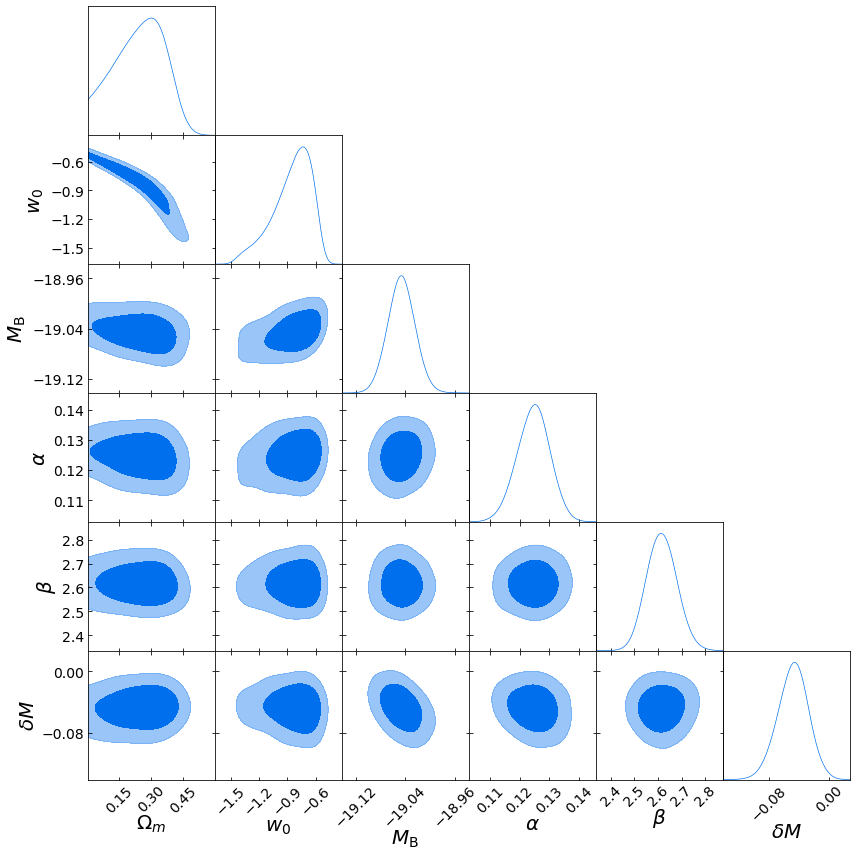

Population 3/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 2s 1ms/step - loss: 6.2464 - val_loss: 6.3691
Epoch 2/100
1800/1800 [==============================] - 2s 910us/step - loss: 6.2483 - val_loss: 6.3682
Epoch 3/100
1800/1800 [==============================] - 1s 640us/step - loss: 6.2424 - val_loss: 6.3400
Epoch 4/100
1800/1800 [==============================] - 1s 648us/step - loss: 6.2321 - val_loss: 6.3331
Epoch 5/100
1800/1800 [==============================] - 1s 649us/step - loss: 6.2247 - val_loss: 6.3350
Epoch 6/100
1800/1800 [==============================] - 1s 655us/step - loss: 6.2238 - val_loss: 6.3813
Epoch 7/100
1800/1800 [==============================] - 1s 656us/step - loss: 6.2290 - val_loss: 6.3889
Epoch 8/100
1800/1800 [==============================] - 1s 646us/step - loss: 6.2320 - val_loss: 6.3292
Epoch 9/100
1800/1800 [================

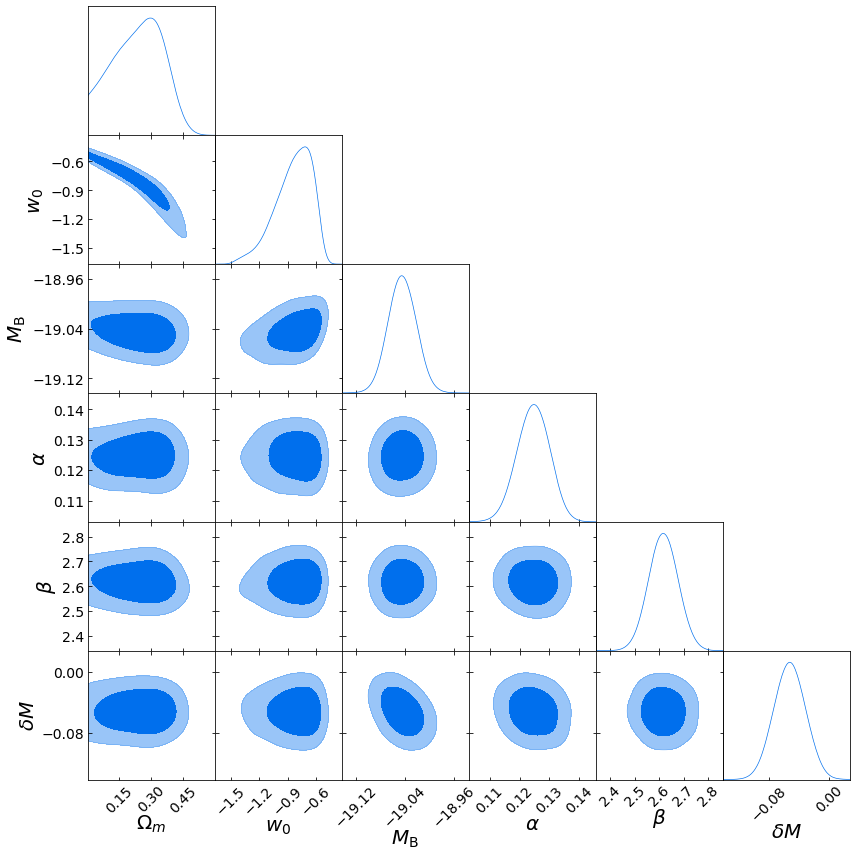

Population 4/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2250 samples, validate on 250 samples
Epoch 1/100
2250/2250 [==============================] - 2s 684us/step - loss: 6.2626 - val_loss: 6.3399
Epoch 2/100
2250/2250 [==============================] - 2s 710us/step - loss: 6.2568 - val_loss: 6.3238
Epoch 3/100
2250/2250 [==============================] - 2s 682us/step - loss: 6.2632 - val_loss: 6.3033
Epoch 4/100
2250/2250 [==============================] - 2s 681us/step - loss: 6.2549 - val_loss: 6.3313
Epoch 5/100
2250/2250 [==============================] - 2s 692us/step - loss: 6.3001 - val_loss: 6.3105
Epoch 6/100
2250/2250 [==============================] - 2s 683us/step - loss: 6.2533 - val_loss: 6.3659
Epoch 7/100
2250/2250 [==============================] - 2s 719us/step - loss: 6.2551 - val_loss: 6.3121
Epoch 8/100
2250/2250 [==============================] - 2s 884us/step - loss: 6.2735 - val_loss: 6.3241
Epoch 9/100
2250/2250 [==============

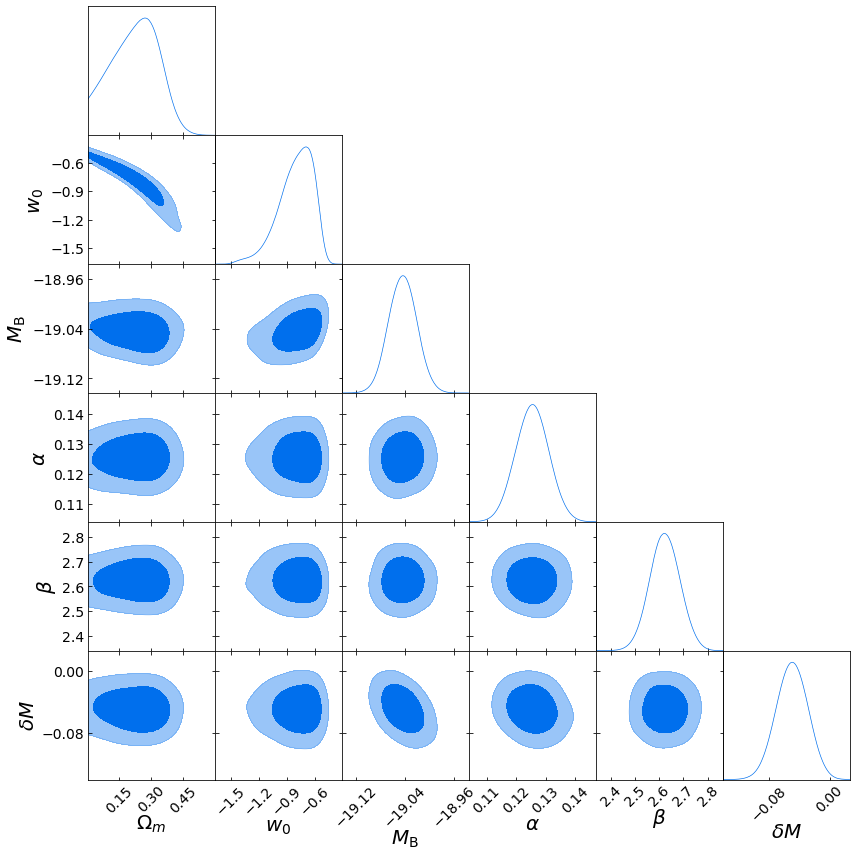

Population 5/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 2s 606us/step - loss: 6.2556 - val_loss: 6.4432
Epoch 2/100
2700/2700 [==============================] - 2s 594us/step - loss: 6.2377 - val_loss: 6.4222
Epoch 3/100
2700/2700 [==============================] - 2s 596us/step - loss: 6.2338 - val_loss: 6.4389
Epoch 4/100
2700/2700 [==============================] - 2s 643us/step - loss: 6.2410 - val_loss: 6.3959
Epoch 5/100
2700/2700 [==============================] - 3s 1ms/step - loss: 6.2378 - val_loss: 6.4059
Epoch 6/100
2700/2700 [==============================] - 2s 638us/step - loss: 6.2263 - val_loss: 6.4492
Epoch 7/100
2700/2700 [==============================] - 2s 621us/step - loss: 6.2388 - val_loss: 6.3852
Epoch 8/100
2700/2700 [==============================] - 2s 621us/step - loss: 6.2210 - val_loss: 6.4023
Epoch 9/100
2700/2700 [================

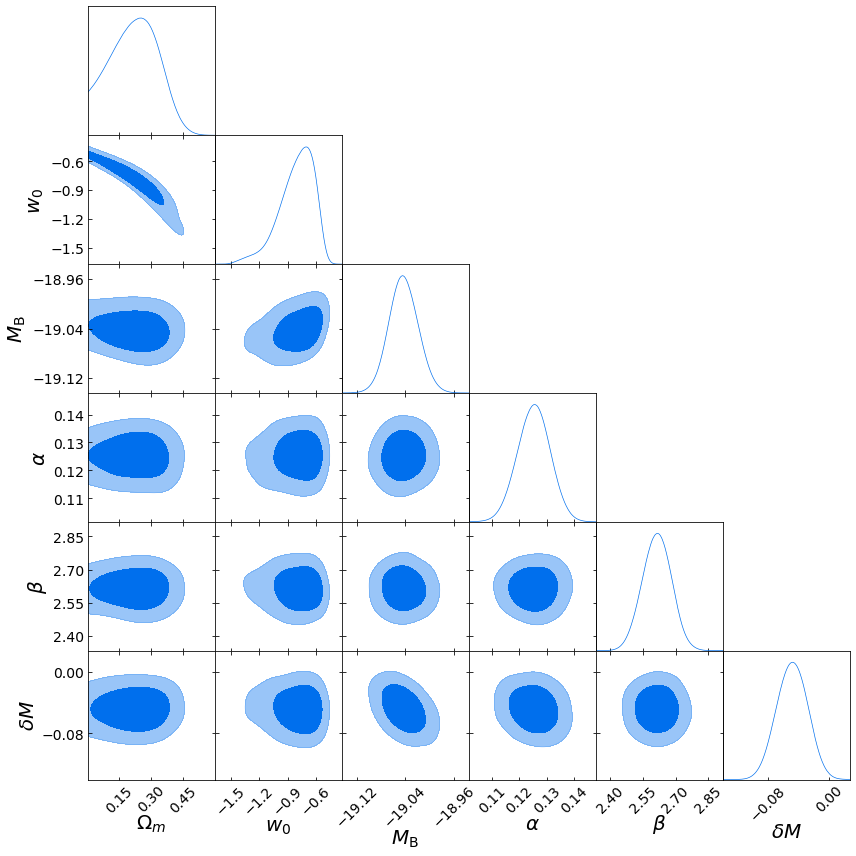

Population 6/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3150 samples, validate on 350 samples
Epoch 1/100
3150/3150 [==============================] - 2s 678us/step - loss: 6.2366 - val_loss: 6.5036
Epoch 2/100
3150/3150 [==============================] - 2s 702us/step - loss: 6.2463 - val_loss: 6.5179
Epoch 3/100
3150/3150 [==============================] - 2s 637us/step - loss: 6.2488 - val_loss: 6.5942
Epoch 4/100
3150/3150 [==============================] - 2s 600us/step - loss: 6.2351 - val_loss: 6.4875
Epoch 5/100
3150/3150 [==============================] - 2s 643us/step - loss: 6.2200 - val_loss: 6.4886
Epoch 6/100
3150/3150 [==============================] - 2s 613us/step - loss: 6.2452 - val_loss: 6.5103
Epoch 7/100
3150/3150 [==============================] - 2s 598us/step - loss: 6.2333 - val_loss: 6.5053
Epoch 8/100
3150/3150 [==============================] - 2s 604us/step - loss: 6.2348 - val_loss: 6.5043
Epoch 9/100
3150/3150 [==============

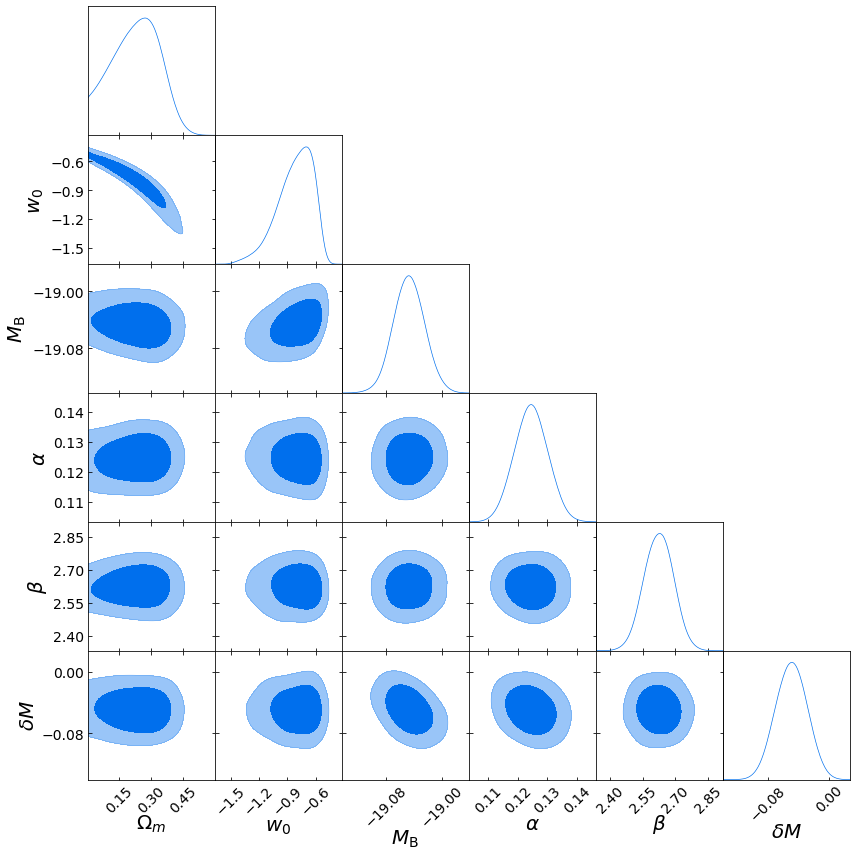

Population 7/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 3600 samples, validate on 400 samples
Epoch 1/100
3600/3600 [==============================] - 2s 607us/step - loss: 6.2343 - val_loss: 6.5221
Epoch 2/100
3600/3600 [==============================] - 2s 607us/step - loss: 6.2358 - val_loss: 6.5099
Epoch 3/100
3600/3600 [==============================] - 2s 606us/step - loss: 6.2368 - val_loss: 6.5643
Epoch 4/100
3600/3600 [==============================] - 2s 608us/step - loss: 6.2204 - val_loss: 6.5233
Epoch 5/100
3600/3600 [==============================] - 2s 602us/step - loss: 6.2204 - val_loss: 6.5095
Epoch 6/100
3600/3600 [==============================] - 2s 600us/step - loss: 6.2138 - val_loss: 6.5330
Epoch 7/100
3600/3600 [==============================] - 2s 631us/step - loss: 6.2217 - val_loss: 6.5346
Epoch 8/100
3600/3600 [==============================] - 2s 603us/step - loss: 6.2358 - val_loss: 6.5193
Epoch 9/100
3600/3600 [==============

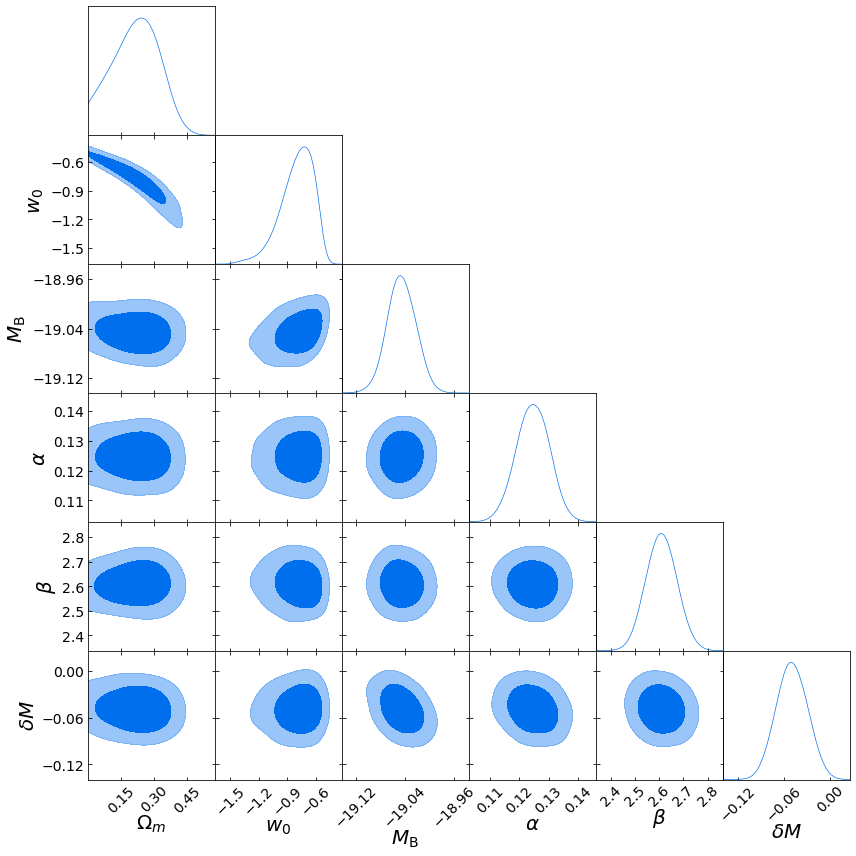

Population 8/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 4050 samples, validate on 450 samples
Epoch 1/100
4050/4050 [==============================] - 2s 595us/step - loss: 6.2419 - val_loss: 6.4981
Epoch 2/100
4050/4050 [==============================] - 2s 593us/step - loss: 6.2544 - val_loss: 6.5227
Epoch 3/100
4050/4050 [==============================] - 2s 598us/step - loss: 6.2628 - val_loss: 6.5758
Epoch 4/100
4050/4050 [==============================] - 3s 709us/step - loss: 6.2761 - val_loss: 6.4907
Epoch 5/100
4050/4050 [==============================] - 2s 593us/step - loss: 6.2473 - val_loss: 6.4728
Epoch 6/100
4050/4050 [==============================] - 2s 598us/step - loss: 6.2485 - val_loss: 6.4827
Epoch 7/100
4050/4050 [==============================] - 3s 620us/step - loss: 6.2526 - val_loss: 6.4897
Epoch 8/100
4050/4050 [==============================] - 2s 591us/step - loss: 6.2467 - val_loss: 6.4798
Epoch 9/100
4050/4050 [==============

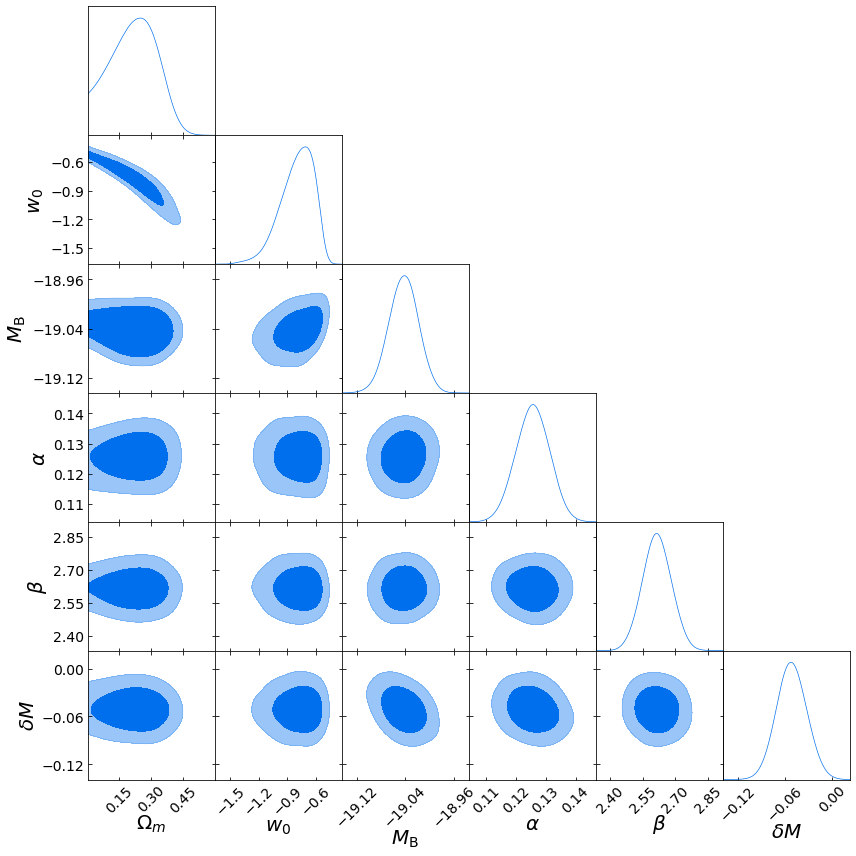

Final round of training with larger SGD batch size...
Train on 4050 samples, validate on 450 samples
Epoch 1/300
4050/4050 [==============================] - 4s 957us/step - loss: 6.2135 - val_loss: 6.5074
Epoch 2/300
4050/4050 [==============================] - 4s 919us/step - loss: 6.2277 - val_loss: 6.5149
Epoch 3/300
4050/4050 [==============================] - 4s 907us/step - loss: 6.2423 - val_loss: 6.5069
Epoch 4/300
4050/4050 [==============================] - 4s 911us/step - loss: 6.2377 - val_loss: 6.4928
Epoch 5/300
4050/4050 [==============================] - 4s 925us/step - loss: 6.2198 - val_loss: 6.4898
Epoch 6/300
4050/4050 [==============================] - 4s 934us/step - loss: 6.2079 - val_loss: 6.4996
Epoch 7/300
4050/4050 [==============================] - 4s 932us/step - loss: 6.2094 - val_loss: 6.5066
Epoch 8/300
4050/4050 [==============================] - 4s 947us/step - loss: 6.2136 - val_loss: 6.4972
Epoch 9/300
4050/4050 [==============================] - 4s

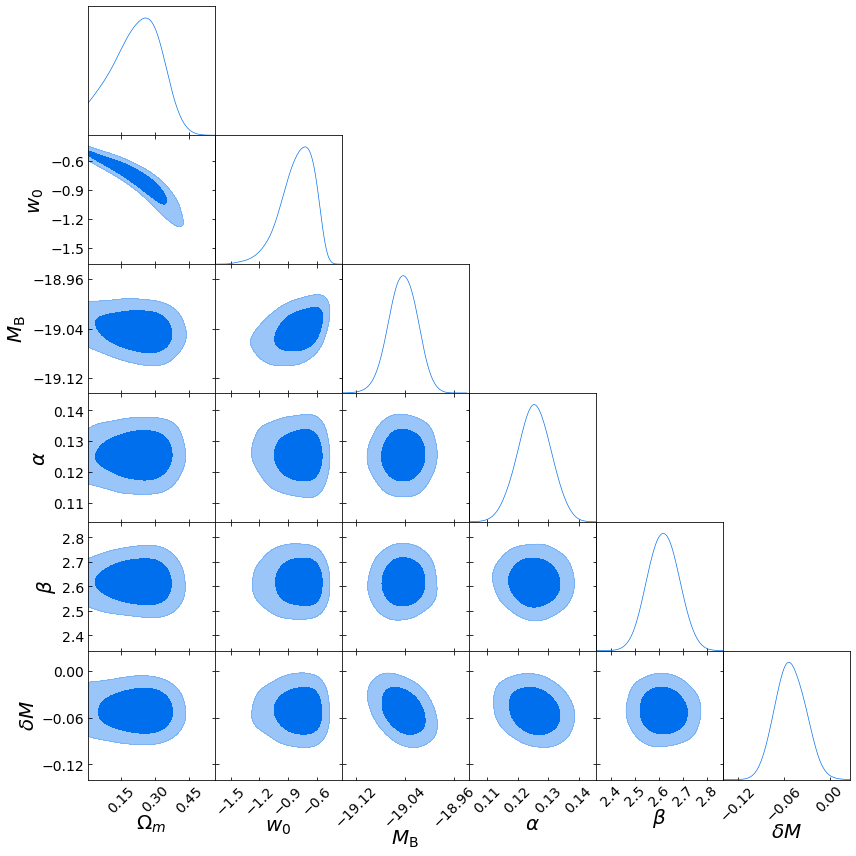

In [16]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 8

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

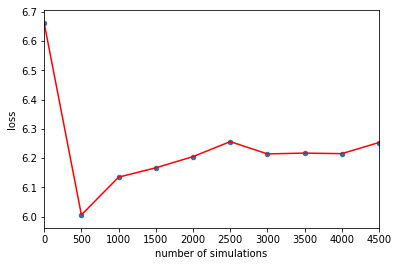

In [17]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()